<a href="https://colab.research.google.com/github/h5ng/influence_functions/blob/master/Time_Series_Classification_with_Kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install fastdtw

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [117]:
origin_X = scipy.io.loadmat('./Trace_half_data.mat')['data']
origin_Y = scipy.io.loadmat('./Trace_half_label.mat')['label'][0]

X, Y = [], []

for i in range(len(origin_Y)):
  if origin_Y[i] == 1 or origin_Y[i] == 4:
    X.append(origin_X[i][25:125])
    Y.append(origin_Y[i])

X = np.array(X)
Y = np.array(Y).reshape(-1, 1)
Y = np.where(Y == 4, -1, Y)

print(np.shape(X))
print(np.shape(Y))
print(Y)

(20, 100)
(20, 1)
[[-1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [-1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [ 1]
 [ 1]
 [-1]
 [ 1]
 [-1]
 [-1]
 [ 1]]


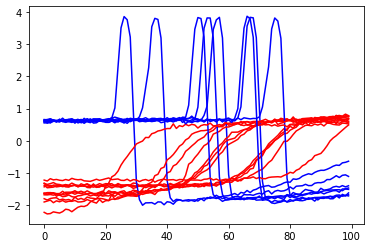

In [118]:
for i in range(len(X)):
  plt.plot(X[i].ravel(), 'b' if Y[i] == 1 else 'r')

plt.show()

In [119]:
batch_size = np.shape(X)[0]
batch_size = 10
X = X[:batch_size]
Y = Y[:batch_size]

X_data = tf.placeholder(shape=[None, np.shape(X)[1]], dtype=tf.float32, name='X_data')
Y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32, name='Y_target')
W = tf.Variable(tf.random_normal(shape=[1, batch_size]), name='weight')

# ??
prediction_grid = tf.placeholder(shape=[None, np.shape(X)[1]], dtype=tf.float32, name='prediction_grid')

print(X_data)
print(Y_target)
print(np.shape(Y.reshape(-1, 1)))
print(W)
print(prediction_grid)

Tensor("X_data_10:0", shape=(?, 100), dtype=float32)
Tensor("Y_target_10:0", shape=(?, 1), dtype=float32)
(10, 1)
<tf.Variable 'weight_10:0' shape=(1, 10) dtype=float32_ref>
Tensor("prediction_grid_10:0", shape=(?, 100), dtype=float32)


In [120]:
def _dtw(X1, X2):
  dtw_array = []
  for i in range(len(X1)):
    tmp_i = []
    for j in range(len(X2)):
      distance = fastdtw(X1[i], X2[j], dist=euclidean)
      tmp_i.append(distance[0])

    dtw_array.append(tmp_i) 
    
  return dtw_array

# n = 10
# r = _dtw(X[:n], X[:n])
# print(np.shape(r))

$k_{GDTW}(x,z) = exp(-\gamma d_{DTW}(x,z))$

In [121]:
gamma = tf.constant(25.0)
dtw_distances = tf.py_function(func=_dtw, inp=[X_data, X_data], Tout=[tf.float32 for i in range(len(X))])

kernel = tf.exp(-tf.multiply(gamma, dtw_distances))

In [122]:
# sess = tf.Session()
# result = sess.run(kernel, feed_dict={X_data: X[:10]})

In [123]:
first_term = tf.reduce_sum(W)

w_vec_cross = tf.matmul(tf.transpose(W), W)
y_target_cross = tf.matmul(Y_target, tf.transpose(Y_target))
second_term = tf.reduce_sum(
    tf.multiply(kernel, tf.multiply(w_vec_cross, y_target_cross))
)
loss = tf.negative(tf.subtract(first_term, second_term))

In [124]:
pred_dtw_distances = tf.py_function(func=_dtw, inp=[X_data, prediction_grid], Tout=[tf.float32 for i in range(len(X))])
pred_kernel = tf.exp(tf.multiply(gamma, pred_dtw_distances))

prediction_output = tf.matmul(tf.multiply(tf.transpose(Y_target), W), pred_kernel)
prediction = tf.sign(prediction_output - tf.reduce_mean(prediction_output))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(Y_target)), tf.float32))

In [125]:
opt = tf.train.GradientDescentOptimizer(0.01)
train = opt.minimize(loss)
init = tf.initialize_all_variables()

sess = tf.Session()
sess.run(init)

In [126]:
loss_vec = []
batch_accuracy = []
for i in range(100):
  rand_index = np.random.choice(len(X), size=batch_size)  
  rand_X = X[rand_index]
  rand_Y = Y[rand_index]

  sess.run(train, feed_dict={X_data: rand_X, Y_target: rand_Y})
  temp_loss = sess.run(loss, feed_dict={X_data: rand_X, Y_target: rand_Y})
  loss_vec.append(temp_loss)
  acc_temp = sess.run(accuracy, feed_dict={X_data: rand_X, Y_target: rand_Y, prediction_grid: rand_X})
  batch_accuracy.append(acc_temp)

  # sess.run(train, feed_dict={X_data: X, Y_target: Y})
  # temp_loss = sess.run(loss, feed_dict={X_data: X, Y_target: Y})
  # loss_vec.append(temp_loss)
  # acc_temp = sess.run(accuracy, feed_dict={X_data: X, Y_target: Y, prediction_grid: X})
  # batch_accuracy.append(acc_temp)

  print(i)
  if (i + 1) % 10 == 0:
    print('Step #' + str(i+1))
    print('Loss = ' + str(temp_loss))

0
1
2
3
4
5
6
7
8
9
Step #10
Loss = 1.6262038
10
11
12
13
14
15
16
17
18
19
Step #20
Loss = 0.5960393
20
21
22
23
24
25
26
27
28
29
Step #30
Loss = 0.39083624
30
31
32
33
34
35
36
37
38
39
Step #40
Loss = -0.25431538
40
41
42
43
44
45
46
47
48
49
Step #50
Loss = -0.71505547
50
51
52
53
54
55
56
57
58
59
Step #60
Loss = -0.35178828
60
61
62
63
64
65
66
67
68
69
Step #70
Loss = -0.6418508
70
71
72
73
74
75
76
77
78
79
Step #80
Loss = -0.6539458
80
81
82
83
84
85
86
87
88
89
Step #90
Loss = -1.2899514
90
91
92
93
94
95
96
97
98
99
Step #100
Loss = -1.346644


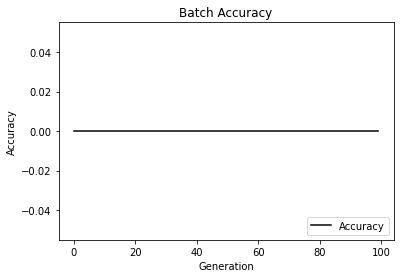

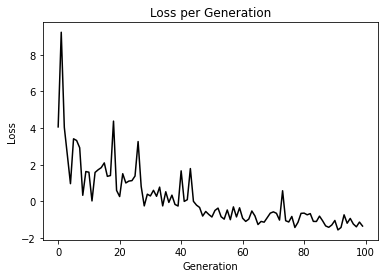

In [127]:
plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [130]:
result = sess.run(prediction, feed_dict={X_data: X, Y_target: Y, prediction_grid: [X[0], X[1]]})
print(result)

[[0. 0.]]
